## Anomaly Detection for NYC Taxi & Limousine Data

In [8]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import math
import shapely as shp
from geopandas import GeoDataFrame
from shapely.geometry import Point
from datetime import datetime
from fiona.crs import from_epsg
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import re
from pandas.tseries.holiday import get_calendar, HolidayCalendarFactory, GoodFriday
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
proj_folder = os.getcwd()

## TLC anomaly detection

In [47]:
### read in data for January 2016
tlc_df_raw = pd.read_csv(proj_folder + '/data/tlc_yellow_2016_1.csv')
tlc_df = tlc_df_raw[['passenger_count', 'trip_distance', 'fare_amount', \
                     'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime']]

In [48]:
tlc_df['tpep_pickup_datetime'] = pd.to_datetime(tlc_df['tpep_pickup_datetime'])
tlc_df['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df['tpep_dropoff_datetime'])
tlc_df.head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,total_amount,tpep_pickup_datetime,tpep_dropoff_datetime
0,2,1.10,7.5,0.5,0.5,0.0,8.8,2016-01-01,2016-01-01
1,5,4.90,18.0,0.5,0.5,0.0,19.3,2016-01-01,2016-01-01
2,1,10.54,33.0,0.5,0.5,0.0,34.3,2016-01-01,2016-01-01
3,1,4.75,16.5,0.0,0.5,0.0,17.3,2016-01-01,2016-01-01
4,3,1.76,8.0,0.0,0.5,0.0,8.8,2016-01-01,2016-01-01


In [50]:
#CANNOT GET THIS TRIP DURATION TO WORK - MOVING ON FOR NOW
#tlc_df['trip_duration'] = pd.Timedelta(tlc_df['tpep_dropoff_datetime_2'] - tlc_df['tpep_pickup_datetime']).seconds / 3600.0
#tlc_df['trip_speed'] = tlc_df.trip_distance / tlc_df.trip_duration

In [58]:
#count the number of taxi trips each day
tlc_df['taxi_date'] = tlc_df['tpep_pickup_datetime'].dt.date
tlc_df_day_count = tlc_df.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_day_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_day_count.head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,taxi_date,taxi_trip_count
0,2016-01-01,345037
1,2016-01-02,312831
2,2016-01-03,302878
3,2016-01-04,316171
4,2016-01-05,343251


In [70]:
#take the mean of the taxi stats each day
tlc_df_stat_agg = tlc_df.groupby(['taxi_date'], as_index=False).mean()
tlc_df_stat_agg.columns = ['taxi_date', 'passenger_count_mean','trip_distance_mean', 'fare_amount_mean',\
                          'extra_amount_mean', 'mta_tax_mean', 'tip_amount_mean', 'total_amount_mean']
tlc_df_stat_agg.head()

,taxi_date,passenger_count_mean,trip_distance_mean,fare_amount_mean,extra_amount_mean,mta_tax_mean,tip_amount_mean,total_amount_mean
0,2016-01-01,1.792785,3.270908,12.856933,0.269715,0.496751,1.451324,15.640110
1,2016-01-02,1.776272,3.065510,12.434471,0.197588,0.497473,1.465769,15.189766
2,2016-01-03,1.737195,3.405868,13.061590,0.199482,0.496981,1.663452,16.098867
3,2016-01-04,1.647561,30.318864,12.207293,0.373599,0.497722,1.640299,15.366877
4,2016-01-05,1.634603,7.723013,12.001867,0.355729,0.497956,1.657823,15.094682


In [87]:
tlc_df_by_day = tlc_df_stat_agg.merge(tlc_df_day_count, on='taxi_date')
tlc_df_by_day.head()

,taxi_date,passenger_count_mean,trip_distance_mean,fare_amount_mean,extra_amount_mean,mta_tax_mean,tip_amount_mean,total_amount_mean,taxi_trip_count
0,2016-01-01,1.792785,3.270908,12.856933,0.269715,0.496751,1.451324,15.640110,345037
1,2016-01-02,1.776272,3.065510,12.434471,0.197588,0.497473,1.465769,15.189766,312831
2,2016-01-03,1.737195,3.405868,13.061590,0.199482,0.496981,1.663452,16.098867,302878
3,2016-01-04,1.647561,30.318864,12.207293,0.373599,0.497722,1.640299,15.366877,316171
4,2016-01-05,1.634603,7.723013,12.001867,0.355729,0.497956,1.657823,15.094682,343251


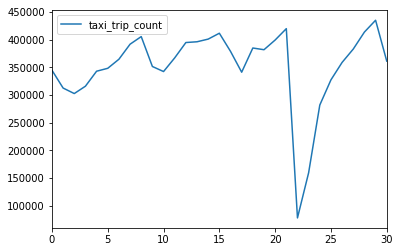

In [72]:
tlc_df_by_day[['taxi_date', 'taxi_trip_count']].plot()

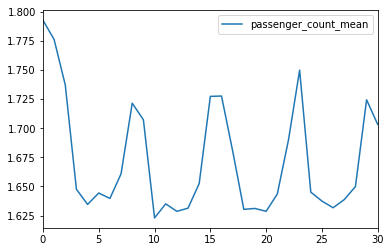

In [73]:
tlc_df_by_day[['taxi_date', 'passenger_count_mean']].plot()

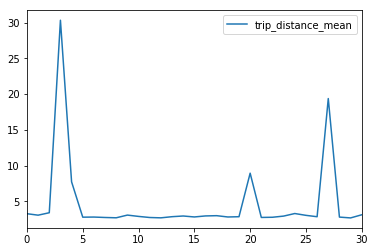

In [75]:
tlc_df_by_day[['taxi_date', 'trip_distance_mean']].plot()

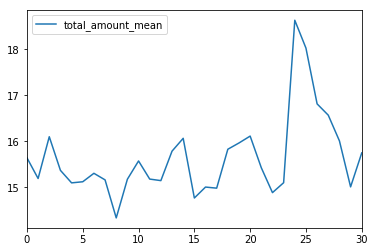

In [77]:
tlc_df_by_day[['taxi_date', 'total_amount_mean']].plot()

In [80]:
X = tlc_df_by_day.iloc[:,1:]
X.head(2)

,passenger_count_mean,trip_distance_mean,fare_amount_mean,extra_amount_mean,mta_tax_mean,tip_amount_mean,total_amount_mean,taxi_trip_count
0,1.792785,3.270908,12.856933,0.269715,0.496751,1.451324,15.640110,345037
1,1.776272,3.065510,12.434471,0.197588,0.497473,1.465769,15.189766,312831


In [82]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.805717743812
For n_clusters =3, the average silhouette_score is :0.598557545137
For n_clusters =4, the average silhouette_score is :0.591736299076
For n_clusters =5, the average silhouette_score is :0.556385719772
For n_clusters =6, the average silhouette_score is :0.522152087557
For n_clusters =7, the average silhouette_score is :0.497593538745
For n_clusters =8, the average silhouette_score is :0.493311579451


In [85]:
GM=GaussianMixture(n_components=2, random_state=324)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=324, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

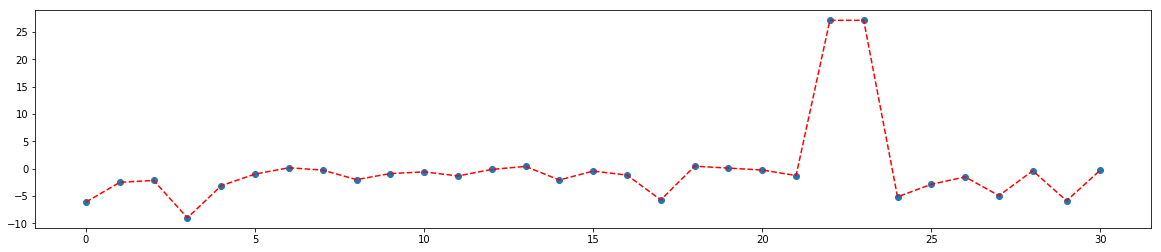

In [86]:
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.plot(GM.score_samples(X),"r--")
plt.show()